# Input-to-Output Shortcut MLP Network


## 1. Pretreatment


Import Configuration.

In [1]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import yaml

import torch
import torch.nn as nn
from torchinfo import summary

with open("./config/I2O_ResMLP.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

Import data.

In [2]:
InputData = sp.io.loadmat(config["DATA_LOADER"]["INPUT_DATA_PATH"])
InputData = torch.from_numpy(InputData["KinematicsData"])
OutputData = sp.io.loadmat(config["DATA_LOADER"]["OUTPUT_DATA_PATH"])
OutputData = torch.from_numpy(OutputData["DynRegData"])

Import `NN_utils` and `Visualization`.

In [3]:
import sys

sys.path.append("../utils")
from NN_utils import *
from Visualization import *

SETUP_SEED(42)
torch.set_default_dtype(torch.float64)

Size of input and output data.

In [4]:
InputData.shape, OutputData.shape

(torch.Size([50000, 8]), torch.Size([50000, 14]))

Create **Training**, **Validation** and **Test** datasets.

In [5]:
TrainingLoader, ValidationLoader, TestLoader = Split2Loaders(
    InputData, OutputData, config
)

## 2. Training


Define MLP network structure.

In [6]:
class DynReg_MLP(nn.Module):
    def __init__(self, input_size, output_size, embedding_size, hidden_size=None):
        if hidden_size is None:
            hidden_size = [16, 32, 16]
        super().__init__()

        # Linear Layer List
        self.NN = nn.ModuleList()

        self.NNstruct = [input_size] + hidden_size + [embedding_size]
        for i in range(len(self.NNstruct) - 1):
            self.NN.append(nn.Linear(self.NNstruct[i], self.NNstruct[i + 1]))

        self.Shortcut = nn.Linear(input_size, output_size, bias=False)
        self.LinearMapping = nn.Linear(embedding_size, output_size, bias=False)

    def forward(self, x):
        Output = x
        for layer in self.NN:
            Output = layer(Output)
            if layer != self.NN[-1]:
                Output = torch.relu(Output)
        Output = self.LinearMapping(Output)
        Output += self.Shortcut(x)
        return Output

Define network.

In [7]:
Net = DynReg_MLP(
    input_size=config["NETWORK"]["INPUT_SIZE"],
    output_size=config["NETWORK"]["OUTPUT_SIZE"],
    embedding_size=config["NETWORK"]["EMBEDDING_SIZE"],
    hidden_size=config["NETWORK"]["HIDDEN_SIZE"],
)
summary(
    Net,
    input_data=torch.zeros(1, InputData.shape[1]),
    device=GET_DEVICE(),
    col_names=["input_size", "output_size", "num_params"],
    col_width=15,
)

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #
DynReg_MLP                               [1, 8]          [1, 14]         --
├─ModuleList: 1-1                        --              --              --
│    └─Linear: 2-1                       [1, 8]          [1, 32]         288
│    └─Linear: 2-2                       [1, 32]         [1, 32]         1,056
│    └─Linear: 2-3                       [1, 32]         [1, 32]         1,056
│    └─Linear: 2-4                       [1, 32]         [1, 8]          264
├─Linear: 1-2                            [1, 8]          [1, 14]         112
├─Linear: 1-3                            [1, 8]          [1, 14]         112
Total params: 2,888
Trainable params: 2,888
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.03

Define loss function.

In [8]:
def SparityLoss(SparityPromotingLayer, OutputFromNet, OutputFromData):
    sparity_loss = 0
    for layer in SparityPromotingLayer:
        for _, param in layer.named_parameters():
            sparity_loss += torch.abs(param).sum()

    return sparity_loss

Define optimizer.

In [9]:
optimizer = torch.optim.Adam(
    Net.parameters(),
    lr=config["TRAIN"]["LEARNING_RATE"],
    weight_decay=config["TRAIN"]["WEIGHT_DECAY"],
)

Training network.

In [10]:
(
    Loss_1_Training_History,
    Loss_1_Validation_History,
    Loss_2_Training_History,
    Loss_2_Validation_History,
) = TRAIN_WITH_PROGRESS_BAR_TWO_LOSS(
    MODEL=Net,
    CONFIG=config,
    OPTIMIZER=optimizer,
    TRAIN_LOADER=TrainingLoader,
    VALIDATION_LOADER=ValidationLoader,
    LOSS_TUPLE=[
        nn.MSELoss(),
        lambda y1, y2: SparityLoss(
            [Net.Shortcut, Net.LinearMapping],
            y1,
            y2,
        ),
    ],
    FREEZE_LAYER=[Net.Shortcut, Net.LinearMapping],
)

PyTorch Version: 2.5.1
Weight initialized with Kaiming Initialization
Training on cpu
====================================Start training====================================


Epoch 50/50: 100%|██████████| 938/938 [00:03<00:00, 300.78batch/s, loss_1=1.32, loss_2=1.1]   


====================================Finish training====================================



## 3. Visualization

Loss-Epoch Diagram

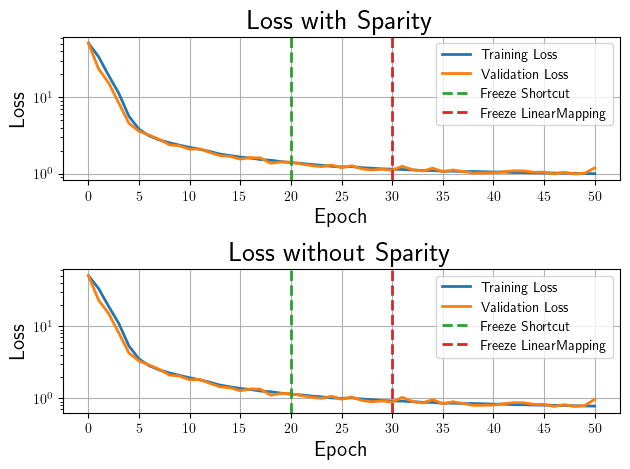

In [11]:
plt.rcParams["text.usetex"] = True
Loss_Epoch_Diagram = LOSS_EPOCH_DIAGRAM_TWO_LOSS(
    LOSS_HISTORY_TUPLE=(
        Loss_1_Training_History,
        Loss_1_Validation_History,
        Loss_2_Training_History,
        Loss_2_Validation_History,
    ),
    CONFIG=config,
    LAYER_NAME=["Shortcut", "LinearMapping"],
)

Final loss.

In [12]:
Loss_2_Validation_History[-1]

0.9661329368519537

Shortcut visualization.

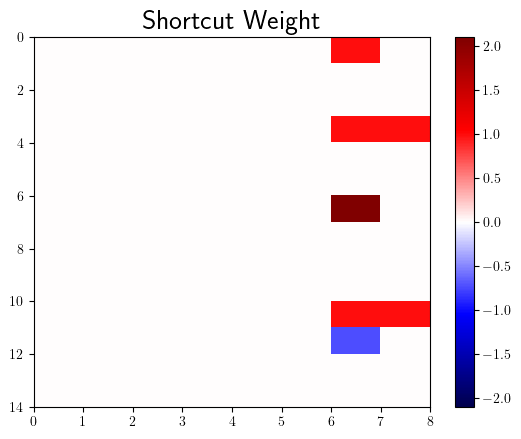

In [13]:
data_temp = Net.Shortcut.weight.detach().to("cpu").numpy()
Shortcut_Weight_Visualization = VISUALIZE_MATRIX(
    data_temp, config["VISUALIZATION"]["SHORTCUT_WEIGHT"], "Shortcut Weight"
)

Linear Mapping Matrix Visualization.

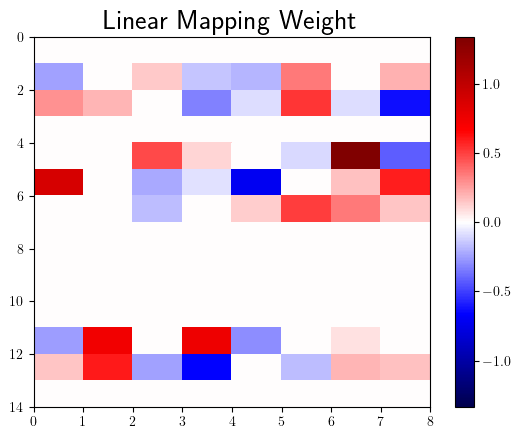

In [14]:
data_temp = Net.LinearMapping.weight.detach().to("cpu").numpy()
Linear_Mapping_Weight = VISUALIZE_MATRIX(
    data_temp, config["VISUALIZATION"]["LINEAR_MAPPING_WEIGHT"], "Linear Mapping Weight"
)

Linear Layer Weight Visualization.

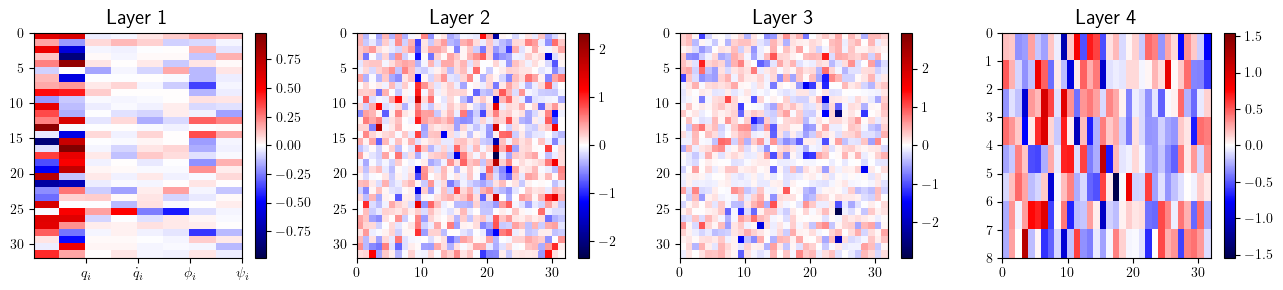

In [15]:
NN_Weight = VISUALIZE_NN(Net.NN, config["VISUALIZATION"]["NN_WEIGHT"])

## 4. Error on Test Data

Test Data

In [16]:
test_input_data = []
test_output_data = []
for data in TestLoader:
    test_input_data += data[0].detach().to(GET_DEVICE(config["TRAIN"]["DEVICE"]))
    test_output_data += data[1].detach().to("cpu")

test_output_fromData = torch.stack(test_output_data).numpy()

Obtain output computed from model.

In [17]:
Net.eval()
test_ouput_fromModel = (
    torch.stack([Net(test_input) for test_input in test_input_data])
    .to("cpu")
    .detach()
    .numpy()
)

Compute standard deviation and extreme error of each element.

In [18]:
import itertools

StandardDeviation = np.zeros((1, test_ouput_fromModel.shape[1]))
ExtremeError = test_ouput_fromModel[:2, :] - test_output_fromData[:2, :]
for i, j in itertools.product(
    range(test_ouput_fromModel.shape[0]), range(test_ouput_fromModel.shape[1])
):
    StandardDeviation[:, j] += np.power(
        test_ouput_fromModel[i, j] - test_output_fromData[i, j], 2
    )
    ExtremeError[0, j] = max(
        ExtremeError[0, j], (test_ouput_fromModel[i, j] - test_output_fromData[i, j])
    )
    ExtremeError[1, j] = min(
        ExtremeError[1, j], (test_ouput_fromModel[i, j] - test_output_fromData[i, j])
    )
StandardDeviation = np.sqrt(StandardDeviation) / test_ouput_fromModel.shape[0]
StandardDeviation = StandardDeviation.reshape(
    -1,
).tolist()
UpperError = ExtremeError[0, :].tolist()
LowerError = ExtremeError[1, :].tolist()

Visualization.

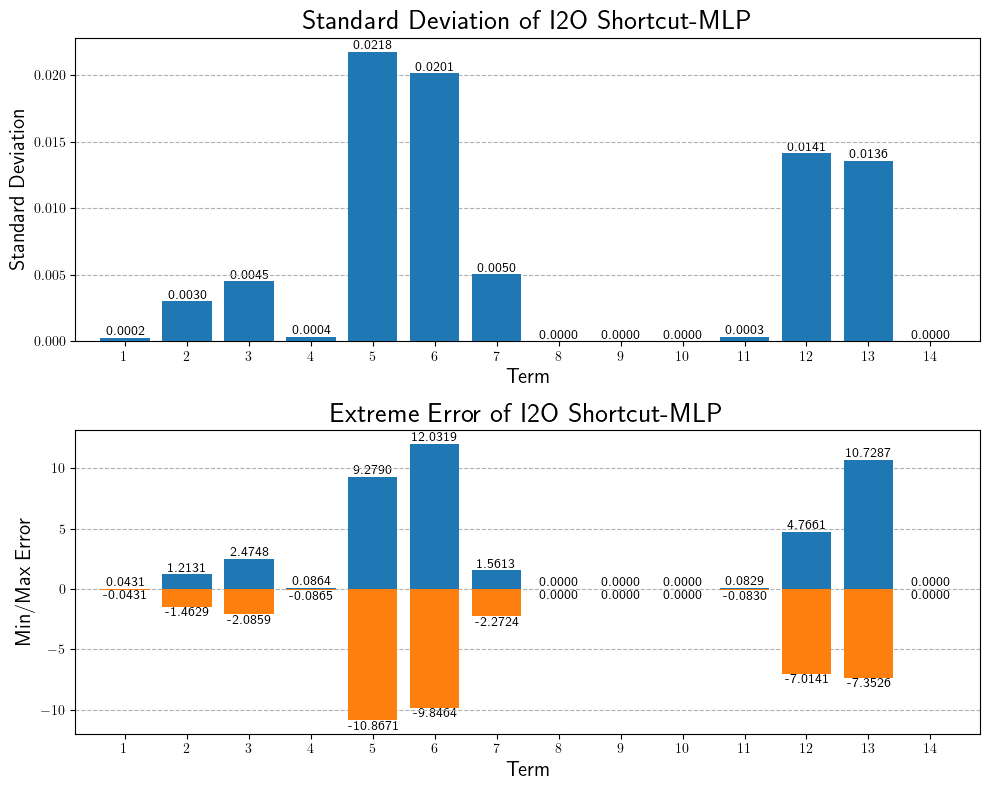

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Standard Deviation
axs[0].bar(np.arange(len(StandardDeviation)) + 1, StandardDeviation, zorder=5)
for i in range(len(StandardDeviation)):
    axs[0].text(
        i + 1,
        StandardDeviation[i],
        "{:.4f}".format(StandardDeviation[i]),
        ha="center",
        va="bottom",
        zorder=1,
    )
axs[0].set_xticks(np.arange(len(StandardDeviation)) + 1)
axs[0].set_xlim([1 - 0.8, len(StandardDeviation) + 0.8])
axs[0].set_title("Standard Deviation of I2O Shortcut-MLP", fontsize=20)
axs[0].set_xlabel("Term", fontsize=15)
axs[0].set_ylabel("Standard Deviation", fontsize=15)
axs[0].grid(axis="y", linestyle="--", zorder=0)

# Upper Error
axs[1].bar(np.arange(len(UpperError)) + 1, UpperError, zorder=5)
# Lower Error
axs[1].bar(np.arange(len(LowerError)) + 1, LowerError, zorder=5)
for i in range(len(UpperError)):
    axs[1].text(
        i + 1,
        UpperError[i],
        "{:.4f}".format(UpperError[i]),
        ha="center",
        va="bottom",
        zorder=1,
    )
    axs[1].text(
        i + 1,
        LowerError[i],
        "{:.4f}".format(LowerError[i]),
        ha="center",
        va="top",
        zorder=1,
    )
axs[1].set_xticks(np.arange(len(UpperError)) + 1)
axs[1].set_xlim([1 - 0.8, len(UpperError) + 0.8])
axs[1].set_title("Extreme Error of I2O Shortcut-MLP", fontsize=20)
axs[1].set_xlabel("Term", fontsize=15)
axs[1].set_ylabel("Min/Max Error", fontsize=15)
axs[1].grid(axis="y", linestyle="--", zorder=0)

plt.tight_layout()
plt.show()

Histogram of dominating error terms.

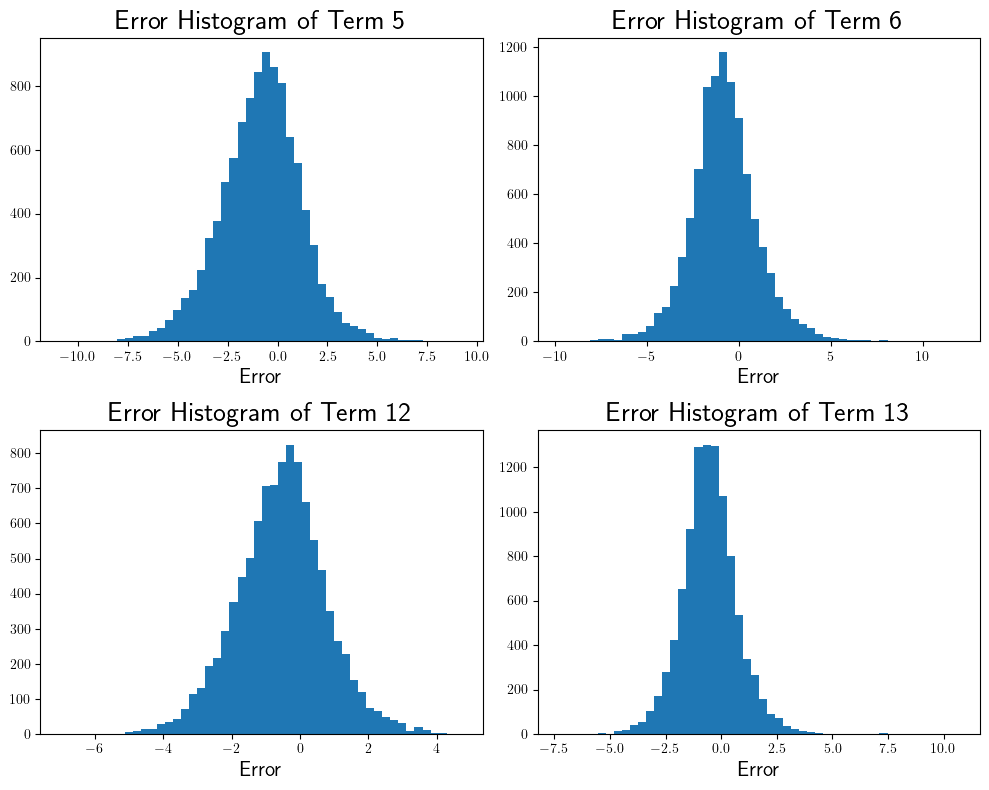

In [20]:
HistedTermIndex = [4, 5, 11, 12]
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i in range(4):
    axs[int(np.floor(i / 2)), np.mod(i, 2)].hist(
        test_ouput_fromModel[:, HistedTermIndex[i]]
        - test_output_fromData[:, HistedTermIndex[i]],
        bins=50,
    )
    axs[int(np.floor(i / 2)), np.mod(i, 2)].set_xlabel("Error", fontsize=15)
    axs[int(np.floor(i / 2)), np.mod(i, 2)].set_title(
        f"Error Histogram of Term {HistedTermIndex[i]+1}", fontsize=20
    )

plt.tight_layout()
plt.show()